# Practica 3 parte 2 
### Presentado por: Maria Camila Bravo


#### Se cuenta con señales de EEG de dos grupos de personas, un grupo control y un grupo de pacientes con enfermedad de Parkinson. Se tiene evidencia que la energía de las señales de EEG puede conducir a diferenciar entre señales de pacientes con enfermedad de Parkinson y sanos. Primero se importan las librerias correspondientes y se carga la carpeta que contiene los datos correspondientes.

In [294]:
import os
import scipy.io as sio;
from scipy.io import loadmat
from scipy.fftpack import fft;
import matplotlib.pyplot as plt;
import numpy as np;
import pandas as pd
from scipy.stats import shapiro, levene, ttest_ind, mannwhitneyu 

#import yasa


In [29]:
!unzip datos_senales_datos_parkinson_cursos.zip

Archive:  datos_senales_datos_parkinson_cursos.zip
   creating: control/
  inflating: control/C001R_EP_reposo.mat  
  inflating: control/C002_EP_reposo.mat  
  inflating: control/C004_EP_reposo.mat  
  inflating: control/C005_EP_reposo_Repetido.mat  
  inflating: control/C006_EP_reposo.mat  
  inflating: control/C007_EP_reposo.mat  
  inflating: control/C010_EP_reposo.mat  
  inflating: control/C011_EP_reposo.mat  
  inflating: control/C012_EP_reposo.mat  
  inflating: control/C013_EP_reposo.mat  
  inflating: control/C015_EP_reposo.mat  
  inflating: control/C018_EP_reposo.mat  
  inflating: control/C019_EP_reposo.mat  
  inflating: control/C020_EP_reposo.mat  
  inflating: control/C021_EP_reposo.mat  
  inflating: control/C023_EP_reposo.mat  
  inflating: control/C024_EP_reposo.mat  
  inflating: control/C025_EP_reposo.mat  
  inflating: control/C026_EP_reposo.mat  
  inflating: control/C027_EP_reposo.mat  
  inflating: control/C028_EP_reposo.mat  
  inflating: control/C029_EP_reposo

## Señal Control
#### La señal control cuenta con 36 archivos, 8 canales o sensores donde Cada fila en senal_continua corresponde a un canal de EEG y  358000  representa el número total de muestras en el tiempo. 

In [249]:
directorio_actual=os.getcwd() #Ruta actual dentro de la consola.
print(directorio_actual)
#listando los archivos en el directorio
archivos=os.listdir(directorio_actual + "/control")
numero_de_sujetos_control = len(archivos)
print(f"Cantidad de sujetos en el grupo de control: {numero_de_sujetos_control}")

#Datos de Fs y Numero de canales.

fs = 1000;
num_canales = 8;

/Users/mcamilabravo/Documents/Universidad 2024:2/Biosenales/Practica3 segunda parte 
Cantidad de sujetos en el grupo de control: 36


In [253]:
# Inicializar una lista para almacenar los datos de todos los sujetos
#CARGAMOS LOS CONTROLES:
datos_control = []
for i in range(0,len(archivos)):  #Itera sobre todos los archivos listados 
    #ruta de un archivo
    sujetoi=(directorio_actual + "/control" + "/" + archivos[i]);  #Eleccion del archivo
    
    #1 CARGAR EL ARCHIVO
    data = sio.loadmat(sujetoi);
    data = data["data"];
    
    #2 VOLVERLO CONTINUO
    num_canales = data.shape[0];  #8 Canales
    puntos = data.shape[1];#2000 puntos
    epocas = data.shape[2]; #179 epocas

    senal_continua = np.reshape(data,(sensores, puntos*epocas), order = 'F');
    datos_control.append(senal_continua)#Dentro del bucle para que se añadan todos

senal_continua.shape  #concatenación de todas las épocas para cada canal en una sola línea de tiempo continua.
#numero de canales 8 y numero de muestres 358000
print(f"Cantidad de señales continuas cargadas: {len(datos_control)}")

Cantidad de señales continuas cargadas: 36


### 1. Energia promedio de cada canal para Control 

In [259]:
# Definir la función para calcular la energía promedio
def calcular_energia_promedio(senal):
    # Calcular energía promedio usando la fórmula
    return np.mean(np.square(senal))

In [260]:
# Inicializar una lista para almacenar la energía promedio de cada canal 
energia_promedio_canales = []

# Aplicar el análisis canal por canal
for c in range(num_canales):
    # Obtener la señal del canal c
    señal_canal = senal_continua[c]
    
    # Calcular la energía promedio del canal
    energia_promedio = calcular_energia_promedio(señal_canal)
    
    # Almacenar el resultado
    energia_promedio_canales.append(energia_promedio)

# Convertir la lista a un array para facilitar el análisis
energia_promedio_canales_control = np.array(energia_promedio_canales)

print("Energía promedio por canal control:")
print(energia_promedio_canales_control)


Energía promedio por canal control:
[ 17.01825139  17.63812112  18.86401709  15.20150639  16.12751223
  74.90246183  97.10929381 135.0805786 ]


### 2. Energía de cada canal promediada por épocas para cada sujeto y DataFrame CONTROL

In [272]:
def calcular_energia_promediada_por_epocas(senal_continua, epocas):

    num_canales = senal_continua.shape[0]  # Número de canales
    puntos_totales = senal_continua.shape[1]
    puntos_por_epoca = puntos_totales // epocas  # Puntos por cada época
    
    energia_promedio_canales = []  # Lista para almacenar la energía promedio por canal
    
    for canal in range(num_canales):  # Iterar por cada canal
        senal_canal = senal_continua[canal]
        energia_por_epoca = []  # Energía para cada época del canal
        
        for e in range(epocas):
            # Selecciona los puntos correspondientes a la época 'e'
            inicio = e * puntos_por_epoca
            fin = (e + 1) * puntos_por_epoca
            epoca = senal_canal[inicio:fin]
            
            # Calcula la energía de la época (mean square)
            energia = np.mean(np.square(epoca))
            energia_por_epoca.append(energia)
        
        # Promediar las energías de todas las épocas para este canal
        energia_promedio_canales.append(np.mean(energia_por_epoca))
    
    return np.array(energia_promedio_canales)  # Convertir la lista en un array para facilidad



Data Frame

In [291]:
# Calcular la energía promedio para cada sujeto en control
energias_por_sujeto_control = [calcular_energia_promediada_por_epocas(senal_continua, epocas) for senal_continua in datos_control]

# Crear DataFrames
df_control = pd.DataFrame(energias_por_sujeto_control, columns=[f'Canal_{i+1}' for i in range(num_canales)])

# Mostrar DataFrames
print("DataFrame Control:")
print(df_control)


DataFrame Control:
      Canal_1    Canal_2    Canal_3    Canal_4    Canal_5     Canal_6  \
0   15.621618  12.111770  14.150609  12.690874  16.541168  120.431804   
1    5.359481   4.339551   1.419110   2.123971   3.971082   12.362454   
2   12.905743  15.577546  14.323545  10.514859   9.126292   74.126960   
3   27.070853  24.556092  26.600279  28.614076  28.411836  119.847082   
4   11.665239  10.896892  10.028722   9.352099  10.595360   45.683183   
5    8.136586   6.538135   6.887906   6.397830   7.011121   35.315358   
6   17.653981  17.458086  19.401116  17.715881  17.955090   53.302166   
7   22.237855  34.294858  38.740979  39.893348  35.193218  172.686667   
8    5.709733   6.946824   7.844472   4.654283   4.959270   19.275091   
9   13.702045  10.524151  22.542188  24.744996  20.109301   21.146509   
10   5.920073  13.227344   7.605477   6.487922   7.187253    3.607089   
11   7.400969  12.688847   7.179754   6.144222   5.847458   16.747375   
12   3.526646   3.242000   3.367

## Señal Parkinson
#### La señal control cuenta con 23 archivos. , 8 canales y 334000 muestras.

In [263]:
#listando los archivos en el directorio
archivos=os.listdir(directorio_actual + "/parkinson")
print(len(archivos))

23


In [279]:
datos_Pks=[]
#CARGAMOS LOS PARKINSON
for i in range(0,len(archivos)):
    #ruta de un archivo
    sujetoi=(directorio_actual + "/parkinson" + "/" + archivos[i]);
    #1 CARGAR EL ARCHIVO
    data = sio.loadmat(sujetoi);
    data_park = data["data"];

    #2 VOLVERLO CONTINUO
    sensores = data_park.shape[0]; #8 Sensores o Canales 
    puntos = data_park.shape[1];
    epocas = data_park.shape[2];# 167 epocas

    senal_continua = np.reshape(data_park,(sensores, puntos*epocas), order = 'F');
    datos_Pks.append(senal_continua)#Dentro del bucle para que se añadan todos los datos de cada sujeto
senal_continua.shape  #concatenación de todas las épocas para cada canal en una sola línea de tiempo continua.
#numero de canales 8 y numero de muestres 334000


(8, 334000)

### 1.Energia promedio por canal 

In [280]:
# Inicializar una lista para almacenar la energía promedio de cada canal
energia_promedio_canales = []

# Aplicar el análisis canal por canal
for c in range(num_canales):
    # Obtener la señal del canal c
    señal_canal = senal_continua[c]
    
    # Calcular la energía promedio del canal
    energia_promedio = calcular_energia_promedio(señal_canal)
    
    # Almacenar el resultado
    energia_promedio_canales.append(energia_promedio)

# Convertir la lista a un array para facilitar el análisis
energia_promedio_canales_Park = np.array(energia_promedio_canales)

print("Energía promedio por canal Parkinson:")
print(energia_promedio_canales_Park)

Energía promedio por canal Parkinson:
[16.09415628 15.57978945 16.17613345 14.40546456 12.68431243 29.76310652
 33.10206618 34.51848492]


### 2. Data Frame PARKINSON
Se llama la funcion usada anteriormente para calcular la energia promedio por epocas de cada sujerto y en este caso se calcula la de Parkinson

In [292]:
energias_por_sujeto_parkinson = [calcular_energia_promediada_por_epocas(senal_continua, epocas) for senal_continua in datos_Pks]

# Crear DataFrames
df_parkinson = pd.DataFrame(energias_por_sujeto_parkinson, columns=[f'Canal_{i+1}' for i in range(num_canales)])

# Mostrar DataFrames
print("DataFrame Parkinson:")
print(df_parkinson)


DataFrame Parkinson:
      Canal_1    Canal_2    Canal_3    Canal_4    Canal_5     Canal_6  \
0   11.715748  13.043537  18.323427  12.832433  15.667187   46.856632   
1    8.845216  13.315119  16.229732  12.774541  11.703040   28.646978   
2   24.966486  23.015287  23.375037  21.556881  21.463061  212.415766   
3   15.567346  10.950190   8.576834  10.266452  15.932466   39.901285   
4   11.012973  10.622525  13.685840   6.600691   9.186188   42.715753   
5   11.870750  11.035755  12.271756  10.903506  11.298854   64.160241   
6    8.003055   6.841406   8.013482   7.243178   7.363749   15.723435   
7    4.788241   7.004493   4.794374   4.686576   4.076727   14.484882   
8    9.000058   6.002863   6.144963   7.394151   8.529812   32.001021   
9    8.101012   6.562741   6.994893   6.376937   7.893705   25.367664   
10   5.465074   7.334990  10.812381   7.725071   6.735770   14.486582   
11  24.294375  25.906598  36.588533  29.852904  28.265830  143.595930   
12  19.049285  21.792644  20.9

## 3. Prueba t y análisis estadístico: 
#### Para verificar si existen diferencias estadísticas entre los canales de los grupos, utiliza una prueba t, primero comprobando normalidad y homocedasticidad:

In [304]:
# Calcular energía promedio por canal
energia_control = df_control.mean(axis=0)
energia_parkinson = df_parkinson.mean(axis=0)

# Verificar normalidad
estadistico_norm_control, p_valor_norm_control = shapiro(energia_control)
estadistico_norm_parkinson, p_valor_norm_parkinson = shapiro(energia_parkinson)

print(f"Normalidad Control: p={p_valor_norm_control}")
print(f"Normalidad Parkinson: p={p_valor_norm_parkinson}")

# Verificar homocedasticidad
estadistico_levene, p_valor_levene = levene(energia_control, energia_parkinson)
print(f"Homocedasticidad: p={p_valor_levene}")

# Realizar prueba t o prueba U de Mann-Whitney
if p_valor_norm_control > 0.05 and p_valor_norm_parkinson > 0.05 and p_valor_levene > 0.05:
    # Supuestos cumplidos, realizar prueba t
    estadistico_t, p_valor_t = prueba_t(energia_control, energia_parkinson)
    print(f"Prueba t: estadístico={estadistico_t}, p={p_valor_t}")
else:
   # Supuestos no cumplidos, realizar prueba U de Mann-Whitney
    estadistico_mw, p_valor_mw = mannwhitneyu(energia_control, energia_parkinson)
    print(f"Prueba U de Mann-Whitney: estadístico={estadistico_mw}, p={p_valor_mw}")

Normalidad Control: p=0.005943167129610663
Normalidad Parkinson: p=0.004758337085815334
Homocedasticidad: p=0.5980168393358286
Prueba U de Mann-Whitney: estadístico=18.0, p=0.1605283605283605


# Grafica 

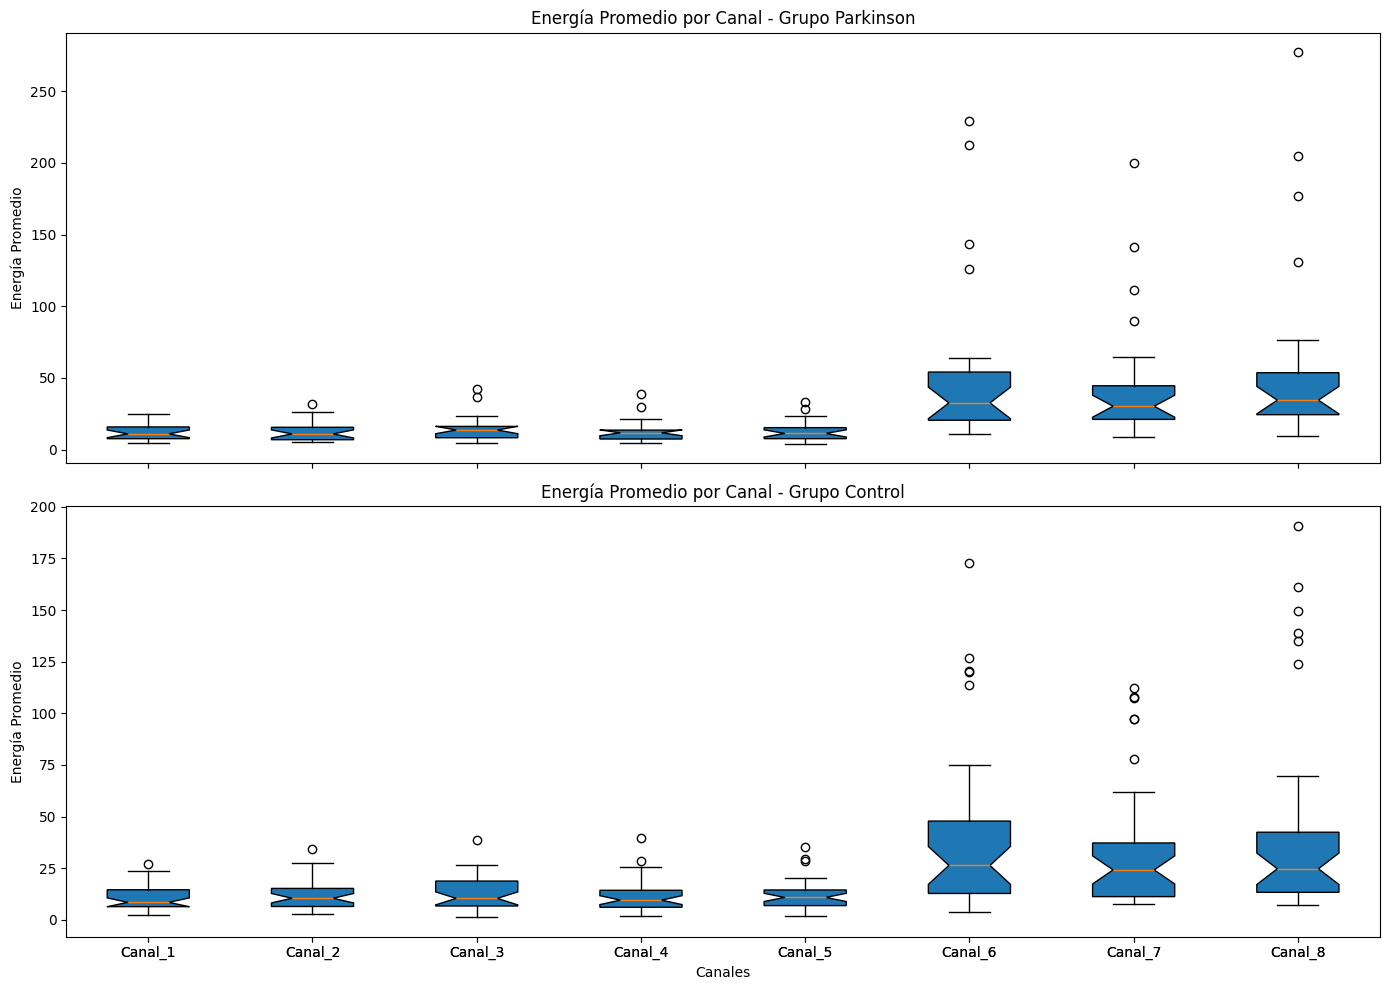

In [307]:
import matplotlib.pyplot as plt

# Definir los nombres de los canales
canales = [f'Canal_{i+1}' for i in range(df_control.shape[1])]

# Crear subgráficas para cada grupo
fig, axs = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Graficar los datos del grupo de Parkinson
axs[0].boxplot(df_parkinson.values, tick_labels=canales, notch=True, patch_artist=True)
axs[0].set_title('Energía Promedio por Canal - Grupo Parkinson')
axs[0].set_ylabel('Energía Promedio')

# Graficar los datos del grupo de Control
axs[1].boxplot(df_control.values, tick_labels=canales, notch=True, patch_artist=True)
axs[1].set_title('Energía Promedio por Canal - Grupo Control')
axs[1].set_xlabel('Canales')
axs[1].set_ylabel('Energía Promedio')




# Ajustar el diseño de las subgráficas
plt.tight_layout()

# Mostrar la gráfica
plt.show()


## Observaciones y Analisis de Resultados

## 1. Energia Promedio por canales Control y Parkinson 
#### Energía promedio por canal control:[ 17.01825139  17.63812112  18.86401709  15.20150639  16.12751223 74.90246183  97.10929381 135.0805786 ]

#### Energía promedio por canal Parkinson: [16.09415628 15.57978945 16.17613345 14.40546456 12.68431243 29.76310652 33.10206618 34.51848492]

#### La energía de una señal mide cuánta "fuerza" o "potencia" tiene la señal. Mientras que los "canales" se refieren a las distintas ubicaciones en el cuero cabelludo donde se colocan los electrodos para medir la actividad eléctrica del cerebro. Cada canal captura la señal de un área específica del cerebro, permitiendo una vista detallada y localizada de la actividad neuronal. Las diferencias en la energía promedio entre los canales del grupo control y del grupo Parkinson son evidentes, especialmente en los canales 6, 7 y 8, donde los pacientes con Parkinson muestran una disminución marcada en la energía a nivel de todos los canales. Cabe destacar que  los valores del grupo control tambien son bastante elevados en los canales 6, 7 y 8, en comparación con los canales 1 a 5. Esta diferencia de disminución en la energía puede ser un indicio de actividad anormal.

## 2. Energia Promedio por Epocas Control y Parkison y DATAFRAME
#### Se calcula la energía de la señal en intervalos temporales (épocas), dividiendo el registro completo en segmentos más pequeños. Esto permite observar cómo varía la energía en el tiempo para cada canal de EEG. En el caso de COntrol para 36 sujentos mientras que para Parkison 23. Después de calcular la energía promedio para cada sujeto en cada grupo, se realizo organizo la información en un Dataframe. Distribuidos entre numero de filas , numero de columnas y Valores que reflejan el promedio de cada sujeto.

#### En el DataFrame Parkinson, los valores para cada canal muestran variabilidad en los datos, destacándose en particular los valores elevados en el Canal_6, donde las energías son notablemente más altas en comparación con otros canales. En contraste, a el DataFrame Control presenta valores que, aunque también varían, muestran una mayor uniformidad en muchos canales en comparación con el grupo de Parkinson, con menos picos extremos. Esta diferencia en la variabilidad y los valores altos en algunos canales del grupo de Parkinson puede indicar características distintas en la energía de las señales EEG entre los dos grupos.

## 3. Pruebas Estadisticas
#### Resultados de Normalidad y Homocedasticidad:

#### Normalidad: el grupo de Parkison para cada canal no parecen cumplir con la normalidad, ya que los p-valores son menores que 0.05, indicando que los datos no siguen una distribución normal.
#### Homocedasticidad: La prueba de Levene para homocedasticidad muestra un p-valor alto (mayor que 0.05), lo que indica que no hay diferencias significativas en las varianzas entre los dos grupos.

#### Dado que los datos para Parkison no son normales y la homocedasticidad muestra que no hay muchas diferencias significativas, se uso la prueba U de Mann-Whitney para comparar las energías promedio entre los grupos. confirmando que no hay diferencias estadisticamente significativas en las energias promedio.




## CONCLUSIONES

#### Se identifico que los valores de energia promedio son mayores en el grupo de Control. Esto podria ayudar a demostrar que durante Parkison la energia de la actividad detectada empieza a disminuir.

#### Los datos para ambos grupos no siguen una distribución normal, según las pruebas de normalidad. Esto sugiere que se deben utilizar métodos estadísticos no paramétricos para análisis futuros.

#### No se encontraron diferencias significativas en las varianzas entre los dos grupos, lo que indica que la homocedasticidad se mantiene. Esto permite la comparación de los grupos sin ajustar por diferencias en la varianza.

#### La prueba U de Mann-Whitney no muestra diferencias estadísticamente significativas en la energía promedio por canal entre el grupo de Parkinson y el grupo Control. Esto podría indicar que, a pesar de las diferencias en la variabilidad de los datos, no hay una diferencia clara en la energía promedio entre los grupos.

#### Se recomienda realizar un análisis adicional utilizando otras métricas o características de las señales EEG para identificar posibles diferencias más sutiles entre los grupos.

## REFERNCIAS 

#### 1. infoSalud. (2019, 21 de mayo). Identifican un biomarcador no invasivo para Parkinson. InfoSalud. https://www.infosalus.com/salud-investigacion/noticia-identifican-biomarcador-no-invasivo-parkinson-20190521081236.html
#### 2. National Institute of Neurological Disorders and Stroke. (n.d.). Enfermedad de Parkinson: Esperanza en la investigación. National Institute of Neurological Disorders and Stroke. https://espanol.ninds.nih.gov/es/trastornos/forma-larga/enfermedad-de-parkinson-esperanza-en-la-investigacion